In [18]:
import numpy as np
import matplotlib.pyplot as plt
from inspect import signature

from ya_glm.toy_data import sample_sparse_lin_reg, sample_sparse_log_reg
from ya_glm.config.loss import Huber
from ya_glm.config.penalty import Lasso, FusedLasso


from ya_glm.GlmTuned import GlmCV, GlmValidation, GlmTrainMetric
from ya_glm.metrics.info_criteria import InfoCriteria
from ya_glm.infer.Inferencer import Inferencer

In [2]:
# sample data from a toy linear regression model
X, y, model_info = sample_sparse_lin_reg(n_samples=100,
                                         n_features=10,
                                         beta_type=2, random_state=1)

# Tuning via cross-validation

In [3]:
# linear regression with Lasso penalty tuned via cross-validation
# simply providing a penalty config to GlmCV will cause the penalty to be tune over
est = GlmCV(penalty=Lasso()).fit(X, y)

# the tuned estimator objects acts just like the single fit estimator
est.fit(X, y) 
print('estimated coefficient', est.coef_)
print('mean square training error', np.mean((est.predict(X) - y) ** 2))

estimated coefficient [ 0.81013885  0.93344889  1.09802458  0.8876758   1.01188189  0.
 -0.24091777 -0.15989345  0.          0.        ]
mean square training error 9.557819685194863


In [4]:
# we can customize how cross-validation happens
# many of these arguments are like sklearn.model_selection.GridSearchCV
est = GlmCV(penalty=Lasso(),
            cv=5, # number of fods
            select_rule='1se', # select using the 1se rule
            scorer='explained_variance',  # see sklearn.metrics.get_scorer
            n_jobs=-1, # use all available nodes for parallelization!
            ).fit(X, y)


# Tuning output

In [5]:
# information tacked for tuning is stored in the tuned_results_ attribute
# that looks a lot like sklearn.model_selection.GridSearchCV's cv_results_
print(np.sort(list(est.tune_results_.keys())))

# Unlike sklearn we track standard errors, not standard deviations

['mean_fit_runtime' 'mean_test_score' 'mean_train_score' 'params'
 'se_fit_runtime' 'se_test_score' 'se_train_score' 'split0_fit_runtime'
 'split0_test_score' 'split0_train_score' 'split1_fit_runtime'
 'split1_test_score' 'split1_train_score' 'split2_fit_runtime'
 'split2_test_score' 'split2_train_score' 'split3_fit_runtime'
 'split3_test_score' 'split3_train_score' 'split4_fit_runtime'
 'split4_test_score' 'split4_train_score']


Text(0.5, 1.0, 'Default lasso penalty tuning path')

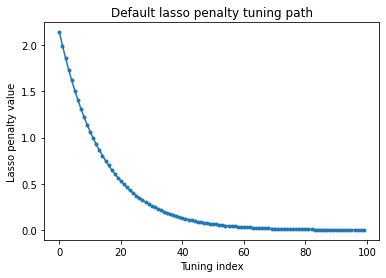

In [6]:
# we create penalty value grids by default whenever possible

# pull put the parameters we tuned over
# TODO: come up with more elegant wat to do this on the back end
pen_val_seq = [list(params.values())[0] for params in  est.tune_results_['params']]

plt.plot(pen_val_seq, marker='.')
plt.xlabel("Tuning index")
plt.ylabel("Lasso penalty value")
plt.title("Default lasso penalty tuning path")

In [7]:
#  Recall the tuning grid is created using the largest reasonable tuning 
# parameter value. We can check this value ensures the lasso coefficient is zero!
from ya_glm.Glm import Glm
pen_max = max(pen_val_seq)
Glm(penalty=Lasso(pen_val=pen_max)).fit(X, y).coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

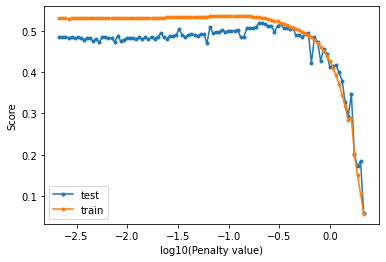

In [8]:
# Plot the cross-validation scores
plt.plot(np.log10(pen_val_seq), est.tune_results_['mean_test_score'],
         marker='.', label='test')
plt.plot(np.log10(pen_val_seq), est.tune_results_['mean_train_score'],
         marker='.', label='train')
plt.xlabel("log10(Penalty value)")
plt.ylabel("Score")
plt.legend()

We provide built in cross-validation visualization diagonistics. 

TODO: @iain re add these to the new version of the package!

# Customizing and manually specifing the tuning parameter grid

Each loss, constraint and penalty config object has as `.tune()` method that returns TuneConfig object that sets up tuning parameter sequences.

In [9]:
# let's see what we can do with the Lasso's tune function
signature(Lasso().tune)

<Signature (n_pen_vals=100, pen_val_seq=None, pen_min_mult=0.001, pen_spacing='log')>

In [10]:
# lets change the tuning grid to have only 10 values
# the panlty argument takes the output of the .tune() method
est = GlmCV(penalty=Lasso().tune(n_pen_vals=10)
            ).fit(X, y)

print("number of tune parameters", len(est.tune_results_['params']))

number of tune parameters 10


In [11]:
# Some penalties cannot automatically create their own tuning parameter grids at this time
# GlmCV(penalty=FusedLasso()).fit(X, y) # uncomment to see error!

# manually specify tuning parameter sequence
pen_val_seq = np.linspace(0, 1, 10)
GlmCV(penalty=FusedLasso().tune(pen_val_seq=pen_val_seq)
      ).fit(X, y)


GlmCV(penalty=<ya_glm.config.base_penalty.PenaltySeqTuner object at 0x7fba18eb96d0>)

# Tuning loss parameters

Some loss functions such as Huber come with parameters that can be tuned over.

In [12]:
# Lasso penalized huber regression
# tuning both the lasso and huber knot via cross-validation

print('tunable parameters', Huber()._tunable_params)

knot_vals = knot=np.arange(1, 5)
est = GlmCV(loss=Huber().tune(knot=knot_vals), # specify knot values via .tune()
            penalty=Lasso(),
            n_jobs=-1 # paralleization
            ).fit(X, y)

# note we parallelize over folds and knot values, but use a path algorithm
# for the lasso penalty sequence

tunable parameters ['knot']


# Path algorithms 

In [13]:
# by default we make use of path algorithms for computing the tuning path
# so long as the solver supports path algorithms. Most solvers do, but not all
# e.g. scipy's linear programming solver does not take warm starts. 


# parallelize over folds, path algorithm for penalty sequence
%time est_path = GlmCV(penalty=Lasso(), n_jobs=-1, path_algo=True).fit(X, y)

# disable path algorithm: parallelize over folds and penalty values
%time est_nopath = GlmCV(penalty=Lasso(), n_jobs=-1, path_algo=False).fit(X, y)

CPU times: user 1.25 s, sys: 353 ms, total: 1.6 s
Wall time: 1.41 s
CPU times: user 14.8 s, sys: 7.54 s, total: 22.4 s
Wall time: 16.5 s


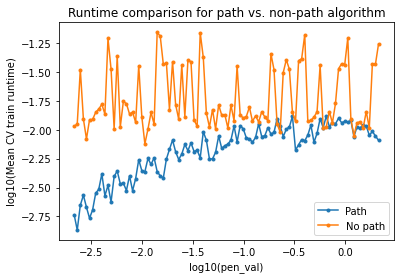

In [14]:
# lets compare the runtime for each parameter value in the tuning path
# for path vs. no path algorithm
pen_val_seq = [list(params.values())[0] for params in est_path.tune_results_['params']]

plt.plot(np.log10(pen_val_seq),
         np.log10(est_path.tune_results_['mean_fit_runtime']),
         marker='.', label='Path')
plt.plot(np.log10(pen_val_seq),
         np.log10(est_nopath.tune_results_['mean_fit_runtime']),
         marker='.', label='No path')
plt.legend()
plt.xlabel('log10(pen_val)')
plt.ylabel("log10(Mean CV train runtime)")
plt.title("Runtime comparison for path vs. non-path algorithm");

# Other tuning parameter methods: validation and information criteria

To use information criteria for linear regression we need to estimate the noise variace parameter. This is discussed later notebook. Below we focus on logistic regression that has no scale parameter!

In [15]:
# sample data from a sprase logistic regression model
X, y, model_info = sample_sparse_log_reg(n_samples=100,
                                         n_features=10,
                                         beta_type=2, random_state=1)

In [16]:
# tune the penalty with a validation set
GlmValidation(loss='log_reg', penalty=Lasso(),
              val=0.2 # use 20% of the data to create a validation test set
              ).fit(X, y)

GlmValidation(loss='log_reg',
              penalty=<ya_glm.config.penalty.Lasso object at 0x7fba18f97550>)

In [17]:
# tune Lasso penalized logistic regression with the extended BIC criterion
# estimate the degrees of freedom via the support of the estimated coefficient
est = GlmValidation(loss='log_reg', penalty=Lasso(),
                    scorer=InfoCriteria(crit='ebic'),
                    inferencer=Inferencer(dof='support') # need
                    ).fit(X, y)